<a href="https://colab.research.google.com/github/valesierrai/Aprendizaje-No-Supervisado-para-el-AD/blob/main/Clase_3_K_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



En la ciudad de Medellín, los accidentes viales representan un desafío significativo para los servicios de emergencia. La ubicación estratégica de ambulancias es crucial para garantizar una respuesta rápida y eficiente. Actualmente, la distribución de ambulancias no siempre permite llegar al lugar de los accidentes en el menor tiempo posible, lo que puede comprometer la atención oportuna a las víctimas.

Para mejorar esta situación, se plantea el siguiente problema: identificar puntos estratégicos para la ubicación de ambulancias que minimicen la distancia recorrida hacia los lugares donde ocurren los accidentes viales.

Se tiene registro de los accidentes viales ocurridos en el año 2021 [Fuente](https://www.medellin.gov.co/geomedellin/datosAbiertos/275).

Cada fila representa un accidente, el data set cuenta con información adicional.

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Conexión con mi unidad en Google Drive

Mounted at /content/drive


In [ ]:
import pandas as pd # manejo de Data Frame en Python
pd.set_option('display.max_columns', 50) # Mostrar mas columnas
import numpy as np
# Librería de gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# Segmentación
from sklearn.cluster import KMeans # K-means
from sklearn.metrics import silhouette_score # Score selección de clúster
from sklearn.preprocessing import StandardScaler # Estandarización

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Aprendizaje No Supervisado/total_incidentes_transito.csv',
                 encoding='latin-1')
df.isna().sum() # Cantidad de datos faltantes

OBJECTID         0
Shape            0
radicado         0
fecha            0
hora             0
dia              0
periodo          0
clase            0
direccion        0
direccion_enc    0
cbml             0
tipo_geocod      0
gravedad         0
barrio           0
comuna           0
diseno           0
dia_nombre       0
mes              0
mes_nombre       0
x_magnamed       0
y_magnamed       0
longitud         0
latitud          0
dtype: int64

In [ ]:
df.head()

,OBJECTID,Shape,radicado,fecha,hora,dia,periodo,clase,direccion,direccion_enc,cbml,tipo_geocod,gravedad,barrio,comuna,diseno,dia_nombre,mes,mes_nombre,x_magnamed,y_magnamed,longitud,latitud
0,1,"(4713091.969499999, 2248782.755800003)",1740037,2021-03-03 00:00:00,12:30:00,3,2021,Atropello,TV 39B CR 74 75,TV 039 B 074 000 00000,Sin inf,Malla vial,HERIDO,Laureles,Laureles Estadio,Lote o Predio,MIÉRCOLES,3,MARZO,832175.31,1182578.79,-75.593827,6.245137
1,2,"(4714910.6292, 2244088.547700003)",1756253,2021-07-26 00:00:00,13:00:00,26,2021,Choque,CRA 48 CLL 4SUR,CR 048 S 004 000 00000,1422,Malla vial,SOLO DAÑOS,La Aguacatala,El Poblado,Interseccion,LUNES,7,JULIO,834016.79,1177893.35,-75.577189,6.202779
2,3,"(4715232.050800002, 2247305.6388000026)",1741056,2021-03-02 00:00:00,6:15:00,2,2021,Choque,CR 50 CL 30 28,CR 050 030 000 00000,1012,Malla vial,HERIDO,Perpetuo Socorro,La Candelaria,Tramo de via,MARTES,3,MARZO,834322.61,1181112.07,-75.574427,6.231878
3,4,"(4716026.328000001, 2254477.3071)",1759316,2021-08-24 00:00:00,22:40:00,24,2021,Otro,CR 65 CL 101 101A,CR 065 101 000 00000,509,Malla vial,HERIDO,Girardot,Castilla,Tramo de via,MARTES,8,AGOSTO,835081.85,1188287.79,-75.567569,6.296749
4,5,"(4718366.126200001, 2248621.4102999996)",1754472,2021-07-16 00:00:00,7:40:00,16,2021,Otro,CL 56 CR 26 28,CL 056 026 000 00000,810,Malla vial aproximada: CL 56-25,HERIDO,El Pinal,Villa Hermosa,Lote o Predio,VIERNES,7,JULIO,837450.38,1182443.14,-75.546170,6.243911


In [ ]:
df.shape # Tamaño del Data Frame

(40599, 23)

Según los datos, han ocurrido 40599 accidentes en Medellín en el año 2021.

¿Cómo a sido la cantidad de accidentes en el tiempo?

Para responder a esta pregunta necesitamos la fecha que ocurrio el accidente.

En los datos, la columna fecha la reconoce como un string pero es posible transformarla en un formato de fecha compatible para realizar analisis, transformar la columna a datetime.

In [ ]:
df["fecha"].head()

0    2021-03-03 00:00:00
1    2021-07-26 00:00:00
2    2021-03-02 00:00:00
3    2021-08-24 00:00:00
4    2021-07-16 00:00:00
Name: fecha, dtype: object

El formato de la fecha es Año-Mes-Día Hora:Minutos:Segundos

Es importante identificar este tipo de formato para poder realizar análisis en el tiempo.

In [ ]:
pd.to_datetime(df["fecha"],
               format='%Y-%m-%d %H:%M:%S') # Conversión a fecha

0       2021-03-03
1       2021-07-26
2       2021-03-02
3       2021-08-24
4       2021-07-16
           ...    
40594   2021-03-25
40595   2021-12-16
40596   2021-08-13
40597   2021-03-20
40598   2021-09-21
Name: fecha, Length: 40599, dtype: datetime64[ns]

In [ ]:
# Creamos una nueva columna
df["Fecha accidente"]= pd.to_datetime(df["fecha"],
               format='%Y-%m-%d %H:%M:%S')

<Axes: xlabel='Fecha accidente', ylabel='Count'>

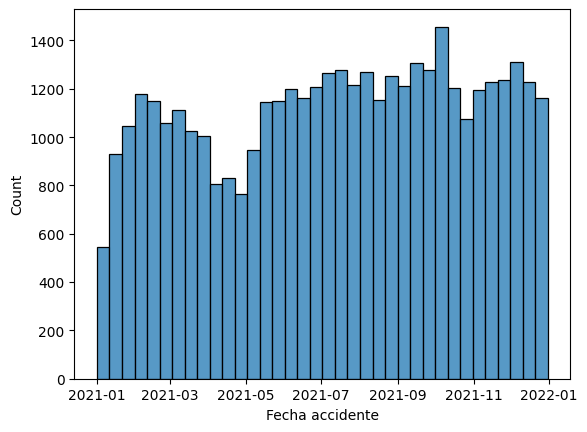

In [ ]:
sns.histplot(df["Fecha accidente"]) # Histograma

In [ ]:
px.histogram(df, x="Fecha accidente") # Histograma interactivo

¿Qué patrón observan?

¿Qué día de la semana ocurren más accidentes?

¿Cómo es la gravedad de los accidentes?

In [ ]:
df['dia_nombre'].value_counts()

dia_nombre
MARTES       6332
VIERNES      6279
MIÉRCOLES    6159
JUEVES       6138
LUNES        5964
SÁBADO       5540
DOMINGO      4187
Name: count, dtype: int64

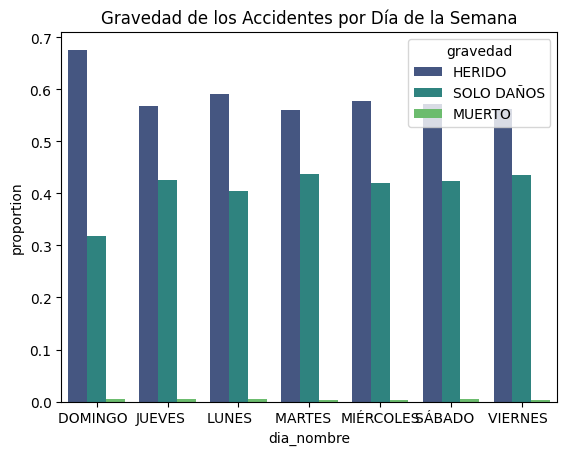

In [ ]:
tabla_frecuencia_relacion= df.groupby('dia_nombre')['gravedad'].value_counts(normalize=True)
sns.barplot(data=tabla_frecuencia_relacion.reset_index(), x='dia_nombre', y='proportion', hue='gravedad',palette="viridis")
plt.title('Gravedad de los Accidentes por Día de la Semana')
plt.show()
#plt.xticks(rotation=90) -> Para poner los nombre en vertical

In [ ]:
df["dia_nombre"]

0        MIÉRCOLES
1        LUNES    
2        MARTES   
3        MARTES   
4        VIERNES  
           ...    
40594    JUEVES   
40595    JUEVES   
40596    VIERNES  
40597    SÁBADO   
40598    MARTES   
Name: dia_nombre, Length: 40599, dtype: object

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'LUNES    '),
  Text(1, 0, 'MARTES   '),
  Text(2, 0, 'MIÉRCOLES'),
  Text(3, 0, 'JUEVES   '),
  Text(4, 0, 'VIERNES  '),
  Text(5, 0, 'SÁBADO   '),
  Text(6, 0, 'DOMINGO  ')])

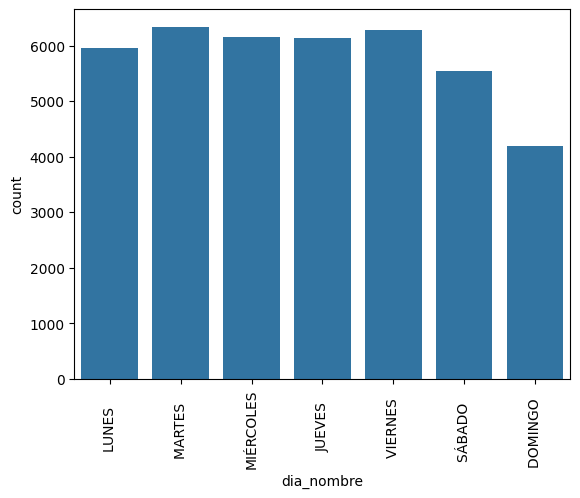

In [ ]:
tabla1=df["dia_nombre"].value_counts().loc[["LUNES    ","MARTES   ","MIÉRCOLES","JUEVES   ","VIERNES  ","SÁBADO   ","DOMINGO  "]]
sns.barplot(tabla1)
plt.xticks(rotation=90)

In [ ]:
px.bar(tabla_frecuencia_relacion.reset_index(), x='dia_nombre', y='proportion', color='gravedad', barmode='group')

In [ ]:
df["gravedad"].value_counts()

gravedad
HERIDO        23651
SOLO DAÑOS    16786
MUERTO          162
Name: count, dtype: int64

¿Cuál podría ser el objetivo de las ambulancias?

¿Cómo nos sirve clustering para este problema?



In [ ]:
fig = px.scatter_mapbox(df, lat="latitud", lon="longitud", color="gravedad")
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

¿Cómo aplicamos K-means considerando dos variables?

- Estandarizar variables.

- Aplicar algoritmo.

- Determinar el número de clúster.

Estandarización

La función StandardScaler aplica la estandarización de variables en nuestro DataFrame.

Por cada columna realiza la siguiente estandarización:

$$
\frac{X-\bar{X}}{S }
$$

Esto hace que las variables se encuentren en una misma escala, generalmente los valores obtenidos cuando se realiza la estandarización estan entre -3, 3.

In [ ]:
df_var= df[["longitud","latitud"]] # Seleccionamos las columnas
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_var)
scaled_features # Transforma a numpy, una matriz

array([[-0.12242   , -0.15281444],
       [ 0.27513395, -1.64965159],
       [ 0.34113519, -0.6213635 ],
       ...,
       [ 0.98617444,  0.6359313 ],
       [ 0.62676048, -0.25951874],
       [ 0.73346374,  0.84848368]])

Algoritmo K-means

Con sklearn podemos aplicar K-means, definimos el número de clúster, definimos una semilla y nos arrojara una etiqueta con los nuevos clústeres.

Pasos:

- Definir los parametros.

- Entrenar el algoritmo con los datos .fit(datos)

- Obtener las etiquetas.



In [ ]:
kmeans = KMeans(n_clusters=2,  random_state=123) # Definir el algoritmo
kmeans.fit(scaled_features)  # Entrenar el modelo
df["cluster"] = kmeans.labels_ # Obtener las etiquetas
df["cluster"] = df["cluster"].astype(str) # Convertir a categoria

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
centros =  df.groupby("cluster")[["latitud","longitud"] ].mean() # obtener el centros

In [ ]:
centros

,latitud,longitud
cluster,,
0,6.253044,-75.575720
1,6.218848,-75.699631


In [ ]:
fig = px.scatter_mapbox(df, lat="latitud", lon="longitud", color="cluster")
fig.add_scattermapbox(lat=centros.reset_index()['latitud'], lon=centros.reset_index()['longitud'],marker_size=10,marker_color="black")

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Número de clústeres

Esta el WCSS y el Score de silueta.

En K-means, se utiliza el llamado método del codo con Within-Cluster Sum of Squares (WCSS) es una medida de la variabilidad dentro de cada cluster. Se calcula sumando las distancias cuadradas entre cada punto y el centroide del cluster al que pertenece. Matemáticamente, se expresa como:

$$ \text{WCSS} = \sum_{k=1}^{K} \sum_{i \in C_k} \| \mathbf{x}_i - \mathbf{\mu}_k \|^2 $$

donde:
- $ K $ es el número de clusters.
- $ C_k $ es el conjunto de puntos pertenecientes al cluster \( k \).
- $ \mathbf{x}_i $ es el \( i \)-ésimo punto de datos.
- $ \mathbf{\mu}_k $ es el centroide del cluster \( k \).
- $ \| \mathbf{x}_i - \mathbf{\mu}_k \|^2 $ es la distancia euclidiana al cuadrado entre el punto $ \mathbf{x}_i $ y el centroide $ \mathbf{\mu}_k $.



# Método del codo

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

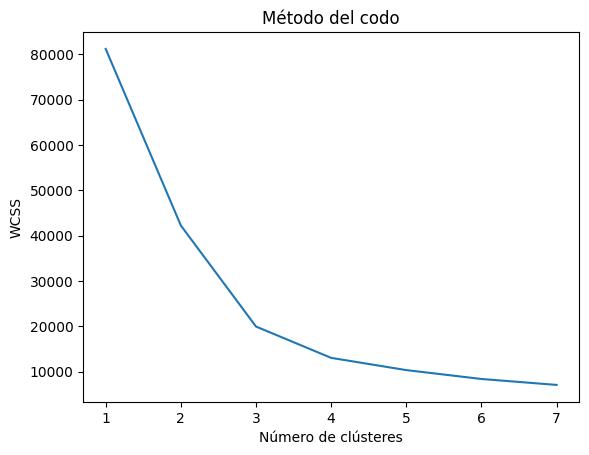

In [ ]:
wcss = [] # valores de WCSS
lista_num_cluster = range(1, 8) # Número de clústeres
# Por cada número de clústeres
for i in lista_num_cluster:
    kmeans = KMeans(n_clusters=i, random_state=123) # Definir el modelo
    kmeans.fit(scaled_features) # entrenar el modelo
    value_wcss= kmeans.inertia_ # extraer el WCSS del modelo
    wcss.append(value_wcss) # Añadir a la lista
# Gráficar resultados
plt.plot(lista_num_cluster, wcss)
plt.title('Método del codo')
plt.xlabel('Número de clústeres')
plt.ylabel('WCSS')
plt.show()

El WCSS siempre va a decreser a mayor número de clústeres, se busca el número de clústeres donde ya no exista un decaimiento significativo.

La elección del número de clústeres puede ser más subjetiva.

Para este caso parece ser que el número de clústeres ideal esta entre 3 a 4.



# Puntuación de silueta

La puntuación de la silueta es una medida de la calidad de los clusters en un análisis de agrupamiento. La ecuación para calcular el valor de la silueta $s(i) $ para un punto de datos $ i $ es:

$$ s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))} $$

donde:
- $a(i) $ es la distancia promedio entre $ i $ y todos los otros puntos en el mismo cluster.
- $b(i) $ es la distancia promedio entre $ i $ y todos los puntos en el cluster más cercano al que $ i $ no pertenece.

El valor de $ s(i) $ está en el rango de -1 a 1, donde:
- Un valor cercano a 1 indica que el punto está bien agrupado.
- Un valor cercano a 0 indica que el punto está en el límite entre dos clusters.
- Un valor cercano a -1 indica que el punto está mal agrupado.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

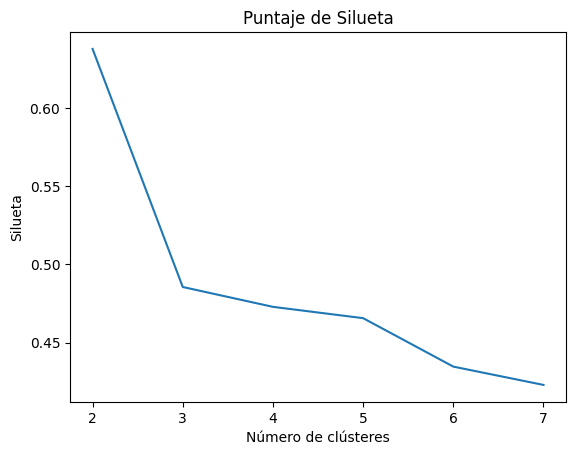

In [ ]:
silueta = [] # valores de puntuación de silueta
lista_num_cluster = range(2, 8) # Número de clústeres
# Por cada número de clústeres
for i in lista_num_cluster:
    kmeans = KMeans(n_clusters=i, random_state=123) # Definir el modelo
    kmeans.fit(scaled_features) # entrenar el modelo
    score_slueta= silhouette_score(scaled_features,  kmeans.labels_)  # Calcular el score
    silueta.append(score_slueta) # Añadir a la lista
# Gráficar resultados
plt.plot(lista_num_cluster, silueta)
plt.title('Puntaje de Silueta')
plt.xlabel('Número de clústeres')
plt.ylabel('Silueta')
plt.show()

Según El puntaje de Silueta el número de clústeres ideal es de 2, aunque si consideramos 3 o 4 clústeres también se obtiene un buen puntaje.

¿Con esta información cuál sería el número de clústeres que ustedes eligen?

In [ ]:
kmeans = KMeans(n_clusters=3,  random_state=123) # Definir el algoritmo
kmeans.fit(scaled_features)  # Entrenar el modelo
df["cluster"] = kmeans.labels_ # Obtener las etiquetas
df["cluster"] = df["cluster"].astype(str) # Convertir a categoria

fig = px.scatter_mapbox(df, lat="latitud", lon="longitud", color="cluster")

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
df["cluster"].value_counts()

cluster
2    18617
1    17738
0     4244
Name: count, dtype: int64

In [ ]:
df["cluster"].value_counts(normalize=True) #Forma de solucionar si tengo una forma de solucionar teniendo un limite de ambulancias

cluster
2    0.458558
1    0.436907
0    0.104535
Name: proportion, dtype: float64